In [5]:
# 飞书资料：https://iv7wt0i3xo.feishu.cn/docx/L50Gd7dCjo5MG0xbHwwcCkR5nmd?from=from_copylink

                             name  \
0  Hilton Garden Seattle Downtown   
1          Sheraton Grand Seattle   
2   Crowne Plaza Seattle Downtown   
3   Kimpton Hotel Monaco Seattle    
4              The Westin Seattle   

                                           address  \
0  1821 Boren Avenue, Seattle Washington 98101 USA   
1   1400 6th Avenue, Seattle, Washington 98101 USA   
2                  1113 6th Ave, Seattle, WA 98101   
3                   1101 4th Ave, Seattle, WA98101   
4   1900 5th Avenue, Seattle, Washington 98101 USA   

                                                desc  
0  Located on the southern tip of Lake Union, the...  
1  Located in the city's vibrant core, the Sherat...  
2  Located in the heart of downtown Seattle, the ...  
3  What?s near our hotel downtown Seattle locatio...  
4  Situated amid incredible shopping and iconic a...  
数据集中的酒店个数： 152
第10个酒店的描述：
Soak up the vibrant scene in the Living Room Bar and get in the mix with our live music and DJ s

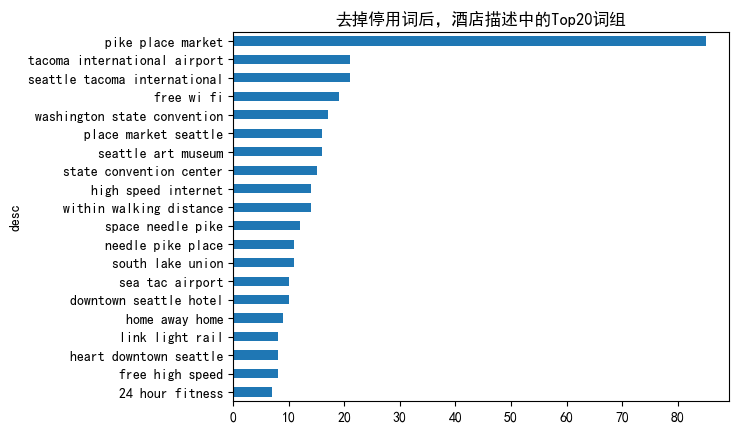

TFIDF 特征数量: 3347
相似度矩阵形状: (152, 152)
['Embassy Suites by Hilton Seattle Tacoma International Airport', 'DoubleTree by Hilton Hotel Seattle Airport', 'Seattle Airport Marriott', 'Four Points by Sheraton Downtown Seattle Center', 'Motel 6 Seattle Sea-Tac Airport South', 'Hampton Inn Seattle/Southcenter', 'Radisson Hotel Seattle Airport', 'Knights Inn Tukwila', 'Hotel Hotel', 'Home2 Suites by Hilton Seattle Airport']
['11th Avenue Inn Bed and Breakfast', 'Shafer Baillie Mansion Bed & Breakfast', 'Gaslight Inn', 'Bed and Breakfast Inn Seattle', 'Chittenden House Bed and Breakfast', 'Hyatt House Seattle', 'Mozart Guest House', 'Silver Cloud Hotel - Seattle Broadway', 'WorldMark Seattle - The Camlin', 'Pensione Nichols Bed and Breakfast']


In [21]:
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import matplotlib.pyplot as plt

# 设置显示参数和中文支持
pd.options.display.max_columns = 30
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体显示

# 1. 加载数据
df = pd.read_csv(r'D:\software\pycharm_repository\StarMaker\MultiRecSys\data_files\Seattle_Hotels.csv', encoding="latin-1")
print(df.head())
print('数据集中的酒店个数：', len(df))

# 英文停用词列表
ENGLISH_STOPWORDS = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
    'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
    "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",
    'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
}

# 打印指定酒店描述信息
def print_description(index):
    example = df[df.index == index][['desc', 'name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Name:', example[1])

print('第10个酒店的描述：')
print_description(10)

# 2. 获取描述中高频n-gram词项
def get_top_n_words(corpus, n=1, k=None):
    vec = CountVectorizer(ngram_range=(n, n), stop_words=list(ENGLISH_STOPWORDS)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:k]

# 可视化Top 20常见词
common_words = get_top_n_words(df['desc'], 3, 20)
df1 = pd.DataFrame(common_words, columns=['desc', 'count'])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的Top20词组')
plt.show()

# 3. 文本清洗规则
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = ENGLISH_STOPWORDS

# 清洗文本函数
def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

# 对 desc 字段进行清洗
df['desc_clean'] = df['desc'].apply(clean_text)

# 基于 TF-IDF 计算酒店之间相似度
# 设置酒店名称为索引
df.set_index('name', inplace=True)

# 提取 TF-IDF 特征（支持 unigram ~ trigram）ngram_range=(1, 3) ： 1元 + 2元 + 3元
# 这行代码的含义是：用词语为单位对文本进行分词，提取所有长度为 1 到 3 的连续词序列（n-grams），去除指定的英文停用词，并过滤掉出现在少于 1% 文档中的低频词项，然后对剩下的词项进行 TF-IDF 编码。
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words=list(ENGLISH_STOPWORDS))
tfidf_matrix = tf.fit_transform(df['desc_clean'])
print('TFIDF 特征数量:', len(tf.get_feature_names_out()))

# 计算余弦相似度（使用线性核）
# linear_kernel 是 sklearn.metrics.pairwise.linear_kernel 提供的一个函数，用来计算两个向量集合之间的 线性核（Linear Kernel）值，
# 也就是：两个向量矩阵之间的点积（内积）。
# 当你用 TfidfVectorizer 得到一个 tfidf_matrix 后，每一行都是一个文本/文档的向量表示，这些向量已经被 L2 正则化（默认行为），所以它们的范数为 1。
# TF-IDF 默认会对每个文本的向量做 L2 归一化，让它的“长度”为 1，从而方便使用点积（linear_kernel）来快速计算余弦相似度。
# L2 归一化把向量“压缩”成长度为 1，但保留方向，让点积直接代表相似度大小，避免受文本长短影响。
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
print('相似度矩阵形状:', cosine_similarities.shape)

indices = pd.Series(df.index)

# 基于相似度进行推荐
def recommendations(name, cosine_similarities=cosine_similarities):
    recommended_hotels = []
    idx = indices[indices == name].index[0]  # 获取酒店索引
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    top_10_indexes = list(score_series.iloc[1:11].index)  # 排除自身，取前10个
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
    return recommended_hotels

# 示例推荐
# 示例推荐：对给定酒店名称生成相似酒店推荐

# 对“Hilton Seattle Airport & Conference Center”这家酒店执行推荐函数
# recommendations() 函数应该是你前面定义的一个函数，内部逻辑大概率是：
# - 根据某种相似度（如 TF-IDF + 余弦相似度）找到与当前酒店最相似的若干家酒店
# - 返回一个包含推荐酒店名称的列表（或 DataFrame）
# - 推荐依据可能是酒店描述、地理位置、评分等特征
print(recommendations('Hilton Seattle Airport & Conference Center'))

# 同样地，对“The Bacon Mansion Bed and Breakfast”这家酒店执行推荐函数
print(recommendations('The Bacon Mansion Bed and Breakfast'))

In [22]:
print('相似度矩阵:')
cosine_similarities

相似度矩阵:


array([[1.        , 0.03930478, 0.09970189, ..., 0.04875507, 0.02296214,
        0.0262131 ],
       [0.03930478, 1.        , 0.05892777, ..., 0.06130707, 0.01516305,
        0.03543109],
       [0.09970189, 0.05892777, 1.        , ..., 0.08718294, 0.04218405,
        0.04985284],
       ...,
       [0.04875507, 0.06130707, 0.08718294, ..., 1.        , 0.05751589,
        0.03948025],
       [0.02296214, 0.01516305, 0.04218405, ..., 0.05751589, 1.        ,
        0.01602277],
       [0.0262131 , 0.03543109, 0.04985284, ..., 0.03948025, 0.01602277,
        1.        ]])

In [23]:
cosine_similarities.shape

(152, 152)

In [24]:
print('清洗之后的DF数据:')
df

清洗之后的DF数据:


,address,desc,desc_clean
name,,,
Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the...",located southern tip lake union hilton garden ...
Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat...",located citys vibrant core sheraton grand seat...
Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ...",located heart downtown seattle awardwinning cr...
Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...,whats near hotel downtown seattle location bet...
The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...,situated amid incredible shopping iconic attra...
...,...,...,...
The Halcyon Suite Du Jour,"1125 9th Ave W, Seattle, WA 98119","Located in Queen Anne district, The Halcyon Su...",located queen anne district halcyon suite du j...
Vermont Inn,"2721 4th Ave, Seattle, WA 98121",Just a block from the world famous Space Needl...,block world famous space needle seattle center...
Stay Alfred on Wall Street,"2515 4th Ave, Seattle, WA 98121",Stay Alfred on Wall Street resides in the hear...,stay alfred wall street resides heart belltown...
